Merge key selected: Date
Silver saved to: abfss://output@mahibasupplychainadls.dfs.core.windows.net/silver/


<Figure size 1000x400 with 0 Axes>

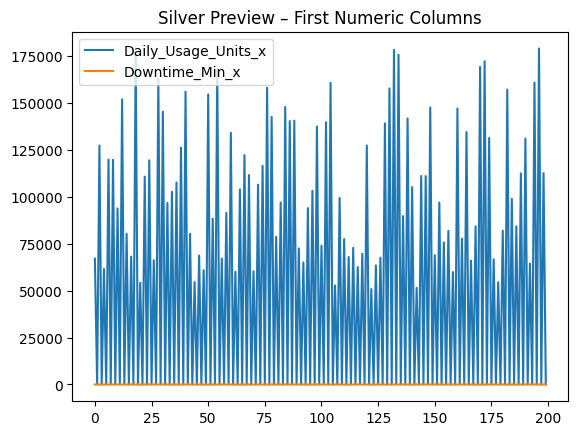

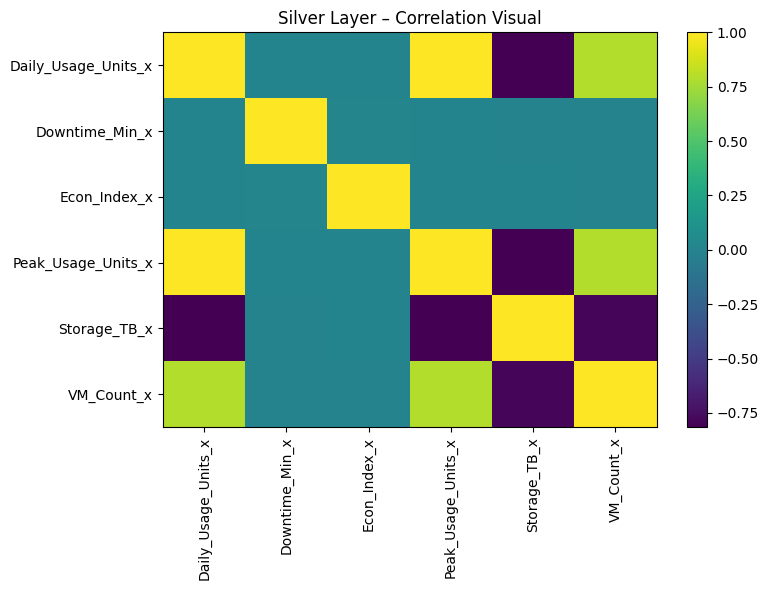

Silver Layer Completed Successfully.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BRONZE_PATH = "abfss://output@mahibasupplychainadls.dfs.core.windows.net/bronze/"
SILVER_PATH = "abfss://output@mahibasupplychainadls.dfs.core.windows.net/silver/"

def load_csv(path):
    return spark.read.option("header", True).csv(path)

def load_json(path):
    return spark.read.option("multiline", "true").json(path)

demand = spark.read.json(BRONZE_PATH + "demand/")
external = load_csv(BRONZE_PATH + "external/")
feateng = load_csv(BRONZE_PATH + "feateng/")

pdf_demand = demand.toPandas()
pdf_external = external.toPandas()
pdf_feateng = feateng.toPandas()

possible_keys = ['date','Date','day','Day','id','ID','product_id','sku']
merge_key = None
for k in possible_keys:
    if k in pdf_demand.columns and (k in pdf_external.columns or k in pdf_feateng.columns):
        merge_key = k
        break

print("Merge key selected:", merge_key)

silver = pdf_demand.copy()

try:
    if merge_key and merge_key in pdf_external.columns:
        silver = pd.merge(silver, pdf_external, on=merge_key, how='left')
    else:
        silver = pd.concat([silver.reset_index(drop=True), pdf_external.reset_index(drop=True)], axis=1)
except Exception as e:
    print("External merge issue:", e)

try:
    if merge_key and merge_key in pdf_feateng.columns:
        silver = pd.merge(silver, pdf_feateng, on=merge_key, how='left')
    else:
        silver = pd.concat([silver.reset_index(drop=True), pdf_feateng.reset_index(drop=True)], axis=1)
except Exception as e:
    print("FeatEng merge issue:", e)

silver.columns = silver.columns.str.strip()

for c in silver.select_dtypes(include=[np.number]).columns:
    silver[c] = silver[c].fillna(silver[c].median())

for c in silver.select_dtypes(include=['object', 'category']).columns:
    silver[c] = silver[c].fillna("UNKNOWN")

spark.createDataFrame(silver).write.mode("overwrite").option("header", True).csv(SILVER_PATH + "silver_merged")

print("Silver saved to:", SILVER_PATH)

plt.figure(figsize=(10,4))
num_cols = silver.select_dtypes(include=["number"]).columns
if len(num_cols) > 0:
    silver[num_cols[:2]].head(200).plot(title="Silver Preview – First Numeric Columns")
    plt.show()
else:
    print("No numeric columns to plot.")

try:
    corr = silver.select_dtypes(include=["number"]).corr()
    if corr.shape[0] > 1:
        plt.figure(figsize=(8,6))
        plt.imshow(corr, aspect='auto')
        plt.colorbar()
        plt.title("Silver Layer – Correlation Visual")
        plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
        plt.yticks(range(len(corr.columns)), corr.columns)
        plt.tight_layout()
        plt.show()
except Exception as e:
    print("Correlation plot skipped:", e)

print("Silver Layer Completed Successfully.")
